In [ ]:
!pip install yargy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=a57461e494d2f1c9adb9c5617a336a2869d023cc9c5c80dfd0c668cbb56d950f
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
from google.colab import drive, userdata
import pandas as pd
# Подключаем гугл диск
drive.mount('/content/drive')


# Определяем путь до данных
path_to_folder = userdata.get('path_to_folder_ppsh')

data = pd.read_csv(path_to_folder + '/Dataset/preprocessing_data.csv', sep='@')
data = data[['task', 'topic', 'new_task']]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подготовка

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import numpy as np
import warnings
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.util import ngrams

from sklearn.preprocessing import OneHotEncoder
from yargy import Parser, rule, and_, or_
from yargy.predicates import gram
from yargy.interpretation import fact, attribute
from yargy.predicates import normalized, dictionary
from yargy.pipelines import morph_pipeline
from yargy.relations import main
from yargy.predicates import in_

from tqdm import tqdm

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
Case = fact('Case', ['name'])
Word = gram('Word')


def split_data(data):
    """
    Функция, которая разделяет датасет на тренировочную и тестовую выборку
    """
    x, y = data[[column for column in data.columns if column != 'y']], data['y']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test


def get_ml_metrics(data, name, X_columns='new_task', y_columns='topic', tf_idf=True, need_processin=True):
    """
    Функция, которая обучает XGBClassifier и возвращает метрику f1-score
    """
    if need_processin:
        data_proc = preprocessing_data(data=data, name=name, X_columns='new_task', y_columns='topic', tf_idf=tf_idf)
    else:
        data_proc = data
    X_train, X_test, y_train, y_test = split_data(data_proc)
    model = XGBClassifier(max_depth=7, random_state=42, n_estimators=500)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    return model, f1_score(y_test, y_pred, average='binary')


def vect_tfidf(vectorizer, text):
    """
    Функция, которая добавляет векторное представлние текста с помощью модели vectorizer
    """
    return vectorizer.transform([text]).toarray()


def preprocessing_data(data, name, X_columns='new_task', y_columns='topic', tf_idf=True):
    """
    Функция, которая векторизует датасет
    """

    # Векторизируем целевую переменную
    data['y'] = data[y_columns].apply(lambda topic_name: 1 if topic_name == name else 0)

    if tf_idf:
        # Векторизуем текст с помощью Tf-Idf
        learn_tf_idf = list(data['new_task'].apply(lambda text: text.lower().split()))

        vectorizer = TfidfVectorizer(max_features=5000, min_df=3)
        vectorizer = vectorizer.fit(data[X_columns])

        train_title_tfidf = np.vstack(data[X_columns].apply(lambda x: vect_tfidf(vectorizer, x)))
        for i in range(len(vectorizer.get_feature_names_out())):
            data[f"Tiidf title f.{i + 1}"] = train_title_tfidf[:, i]

    # Возвращаем обработанный датасет
    data.drop(columns=[X_columns, y_columns], inplace=True)
    return data

def get_word_cloud(data, topic):
    """
    Функция, которая строит облако слов
    """
    df = data[data.topic == topic]
    text = ' '.join(df['new_task'])
    text_tokens = word_tokenize(text)
    cloud = WordCloud(stopwords=stop_words,
                      background_color='white').generate(' '.join(text_tokens))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(topic)
    plt.show()


def get_n_grams(data, topic, n, k, start_slice=0):
    """
    Функция, которая строит график n-grams
    """
    df = data[data.topic == topic]
    words = ' '.join(df.new_task)
    words = ' '.join(list(filter(lambda x: len(x) >= 2, (words.split()))))
    tokens = nltk.word_tokenize(words)

    ngrams_list = list(ngrams(tokens, n))
    freq_dist = dict(FreqDist(ngrams_list))
    sorted_data = sorted(freq_dist.items(), key=lambda x: -x[1])

    y_labels = [str(key) for key, _ in sorted_data][start_slice:start_slice+k][::-1]
    x_values = [value for _, value in sorted_data][start_slice:start_slice+k][::-1]

    plt.barh(y_labels, x_values)
    plt.xlabel('Значение')
    plt.ylabel('N-grams')
    plt.title(topic)
    plt.show()



def extract_phrases(text, parser):
    """
    Функция для извлечения словосочетаний из текста
    """
    matches = parser.findall(text)
    phrases = []
    for match in matches:
        phrases.append(' '.join([word.value for word in match.tokens]))
    return phrases


def make_topic_one_to_one(topic: list):
    """
    Функция для формирования pipline слова
    """
    return morph_pipeline(topic).interpretation(
          Case.name.const(topic[0])
      ).interpretation(
          Case
      )


def add_keywords(df, keywords, column_name):
    """
    Функция, которая добавляет ключевые слова в dataset
    """
    if type(keywords[0]) is tuple:
        alls_word_pipe = []
        for word in keywords:
            alls_word_pipe.append(make_topic_one_to_one(["".join(word)]))
            df[word] = np.NaN

        ALL = or_(*alls_word_pipe).interpretation(Case)
        parser = Parser(ALL)

        for ind, elem in enumerate(tqdm(df[column_name])):
            for match in parser.findall(str(elem)):
                df.loc[ind, match.fact] = 1
        result_df = df
    else:
        alls_word_pipe = []
        for word in keywords:
            alls_word_pipe.append(make_topic_one_to_one([word]))
            df[word] = np.NaN

        ALL = or_(*alls_word_pipe).interpretation(Case)
        parser = Parser(ALL)

        for ind, elem in enumerate(tqdm(df[column_name])):
            for match in parser.findall(str(elem)):
                df.loc[ind, match.fact] = 1
        result_df = df
    result_df.fillna(0, inplace=True)
    return result_df

def visualization_feature_importances(model, data, top_k=10):
    '''
    Функция, которая визуализирует важность признаков модели

    Параметры:
      model - обученная модель
      data - данные, на которых обучалась модель
      top_k - количество первых признаков для отображения (по умолчанию 10)
    '''

    feature_importance = model.feature_importances_
    feature_names = [x for x in data.columns if x != 'y']

    sorted_idx = np.argsort(feature_importance)[::-1]  # Изменяем порядок сортировки

    plt.figure(figsize=(10, 6))

    plt.barh(range(top_k),
             feature_importance[sorted_idx][:top_k],  # Взять только первые top_k значений
             align='center')

    plt.yticks(range(top_k),
               [feature_names[i] for i in sorted_idx][:top_k],  # Взять только первые top_k признаков
               fontsize=10)

    plt.xlabel('Важность факторов')
    plt.ylabel('Факторы')
    plt.title('График важности факторов')

    plt.show()

    return [feature_names[i] for i in sorted_idx][:top_k][::-1]  # Вернуть только первые top_k признаков в обратном порядке

# Анализ данных

Анализируем облако слов, их частоность, n-grams, чтобы выделить ключевые слова

## Геометрия

### Анализ

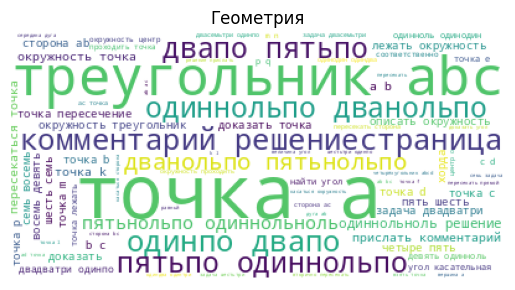

In [ ]:
get_word_cloud(data=data, topic='Геометрия')

In [ ]:
# Массив ключевых слов
geoma_array_1 = [
    "окружность", "угол", "доказать", "треугольник", "пересекаться", "сторона", "центр",
    "точка", "параллельность", "хорда", "вершина", "высота", "пересечение", "прямая",
    "касательная", "лежать", "проходить", 'четырехугольник', 'дуга', 'середина'
]

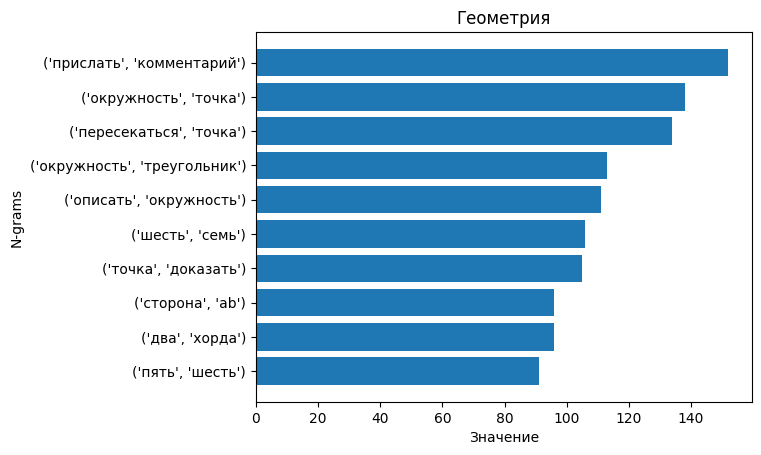

In [ ]:
# Анализ 2-grams
get_n_grams(data=data, topic='Геометрия', n=2, k=10, start_slice=10)

In [ ]:
# Массив ключевых словосочетаний
geoma_2_grams = [
    ("треугольник", "abc"), ("точка", "лежать"), ("окружность", "точка"), ("пересекаться", "точка"),
    ("окружность", "треугольник"), ("описать", "окружность"), ("лежать", "окружность"), ("угол", "касательная"),
    ("окружность", "проходить"), ("окружность", "проходить"),  ("касаться", "окружность"), ("остроугольный", "треугольник"),
    ("прямоугольный", "треугольник"), ("тупоугольный", "треугольник"), ("вписать", "окружность")
]

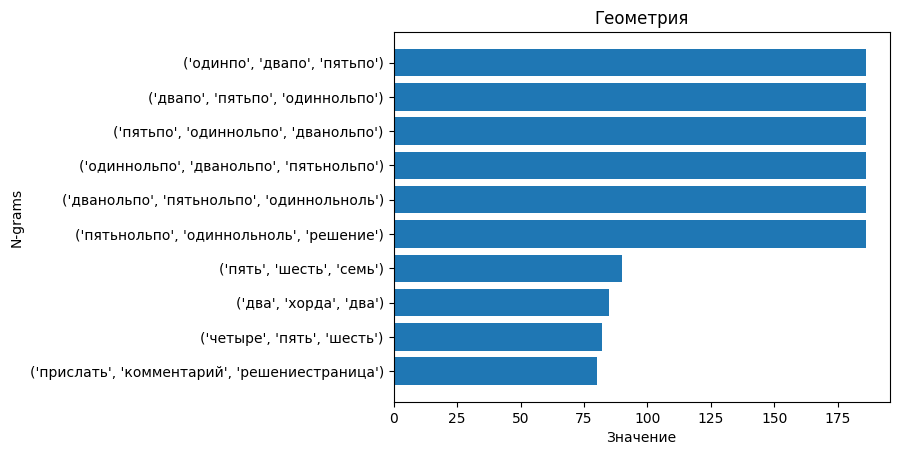

In [ ]:
# Анализ 3-grams
get_n_grams(data=data, topic='Геометрия', n=3, k=10, start_slice=0)

### Отбор признаков

In [ ]:
# Добавляем отобранные слова
data_1 = add_keywords(df=data, keywords=geoma_array_1, column_name='task')
data_1 = add_keywords(df=data_1, keywords=geoma_2_grams, column_name='task')

100%|██████████| 5616/5616 [05:07<00:00, 18.26it/s]


In [ ]:
data_1.to_csv('geoma_1.csv', sep='@')

In [ ]:
# Обучаем на всех признаках
data_1_1 = data_1[[column for column in data_1.columns if column != 'task' and 'title' not in column]]
data_1_2 = data_1_1.copy()

In [ ]:
model, score = get_ml_metrics(data_1_2, name='Геометрия', X_columns='new_task', y_columns='topic', tf_idf=False)
print(score)

0.896551724137931


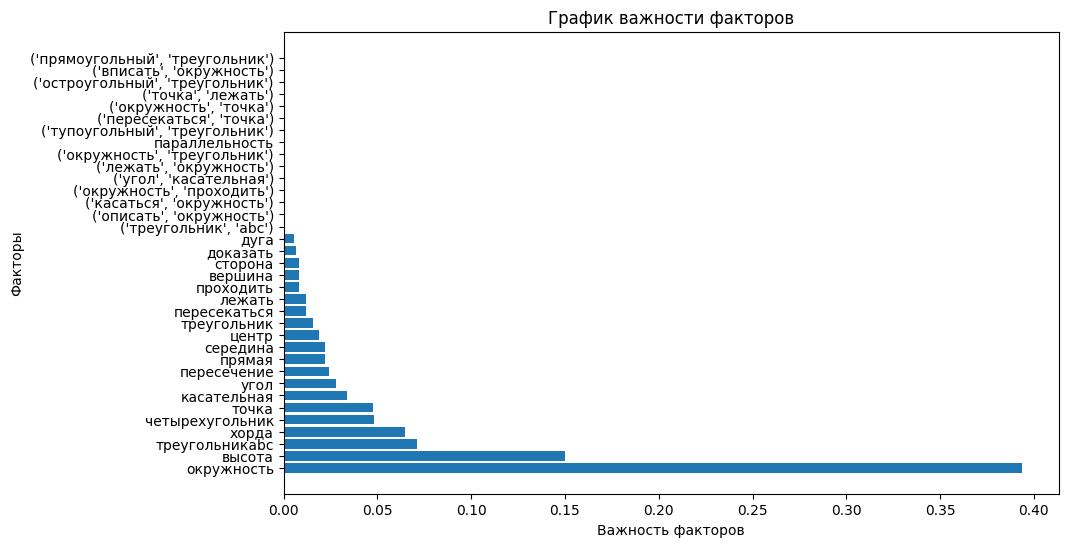

In [ ]:
columns_to_train = visualization_feature_importances(model=model, data=data_1_2, top_k=35)

In [ ]:
# Выбираем лучшее количество фич
columns_to_train = columns_to_train[::-1]
columns_to_train_1 = columns_to_train.copy()
columns_to_train_1.append('topic')
columns_to_train_1.append('new_task')
max_score = 0
best_top_k = 0
for top_k in range(0, len(data_1_2.columns) - 1):
    data_1_3 = data_1_1[columns_to_train_1[top_k:]]
    model, score = get_ml_metrics(data_1_3, name='Геометрия', X_columns='new_task', y_columns='topic', tf_idf=False)
    if score > max_score:
      max_score = score
      best_top_k = len(data_1_2.columns) - 1 - top_k
    print(f"iter - {top_k}, первая колонка - {columns_to_train_1[top_k:][0]}, score - {score}, max_score - {max_score}")
print(max_score, best_top_k)

iter - 0, первая колонка - ('прямоугольный', 'треугольник'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 1, первая колонка - ('вписать', 'окружность'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 2, первая колонка - ('остроугольный', 'треугольник'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 3, первая колонка - ('точка', 'лежать'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 4, первая колонка - ('окружность', 'точка'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 5, первая колонка - ('пересекаться', 'точка'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 6, первая колонка - ('тупоугольный', 'треугольник'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 7, первая колонка - параллельность, score - 0.896551724137931, max_score - 0.896551724137931
iter - 8, первая колонка - ('окружность', 'треугольник'), score - 0.896551724137931, max_score - 0.896551724137

In [ ]:
columns_to_train[::-1][:16]

['окружность',
 'высота',
 'треугольникabc',
 'хорда',
 'четырехугольник',
 'точка',
 'касательная',
 'угол',
 'пересечение',
 'прямая',
 'середина',
 'центр',
 'треугольник',
 'пересекаться',
 'лежать',
 'проходить']

In [ ]:
geoma_final_featuring = ['окружность', 'высота', 'треугольникabc', 'хорда', 'четырехугольник',
                         'точка', 'касательная', 'угол', 'пересечение', 'прямая', 'середина',
                         'центр', 'треугольник', 'пересекаться', 'лежать', 'проходить']

In [ ]:
# Получаем score модели c tf-idf
featuring_to_learn = geoma_final_featuring + ['topic',	'new_task']
model, score = get_ml_metrics(data_1[featuring_to_learn], name='Геометрия', X_columns='new_task', y_columns='topic')
print(score)

0.9252336448598131


In [ ]:
def del_garbage(text):
    return text.strip('.,)?.<*&^%$#@!~')\
               .replace(u'\u00A0', ' ')\
               .replace(u'\x0c', ' ')\
               .replace('\n', '').replace('\t', '')\
               .replace('\r', '').replace('', '')\
               .replace('\r', '')

In [ ]:
data.task = data.task.apply(del_garbage)

In [ ]:
data.to_excel('data.xlsx')

IllegalCharacterError: Задача 19. (МГУ, мехмат, 2004-03.4 ) В выпуклом четырехугольнике KLM N диагоналиKM √и LN перпендикулярны соответственно сторонам M N и KL, а длина стороны KN равна 4 3. На стороне KN расположена точка A так, что ∠LAK = ∠M AN . Известно, что∠M KN − ∠KN L =√15◦ . Найдите длину ломаной LAM и площадь четырехугольника KLM N ,если LA : AM = 1 : 3. √ √√ 63+1 ; 3 3+ 33  cannot be used in worksheets.

## Дирихле

## Инвариант

## Многочлен

## Комбинаторика

## Оценка+Пример

## Теория чисел

## Графы